In [18]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from models import MambaModel, MambaModelLooped, TransformerModelLooped
from curriculum import CurriculumSimple
from train import train_without_config, validate_model

n_dims = 10

In [5]:
mamba_base_l2 = MambaModel(
    n_dims=n_dims,
    n_positions=101,
    n_embd=256,
    n_layer=2,
    pred_type="regression",
).cuda()

mamba_base_l2.load_state_dict(
    torch.load("scripts/models/mamba/model_mamba_base_L2.pt")["model_state_dict"])

number of parameters: 0.88M


<All keys matched successfully>

In [38]:
mamba_loop_b5 = MambaModelLooped(
    n_dims=n_dims,
    n_positions=101,
    n_embd=256,
    n_layer=1,
    pred_type="regression",
).cuda()

mamba_loop_b5.load_state_dict(
    torch.load("scripts/models/mamba/model_mamba_looped_L1_b5.pt")["model_state_dict"])

number of parameters: 0.44M


<All keys matched successfully>

In [9]:
mamba_loop_b10 = MambaModelLooped(
    n_dims=n_dims,
    n_positions=101,
    n_embd=256,
    n_layer=1,
    pred_type="regression",
).cuda()

mamba_loop_b10.load_state_dict(
    torch.load("scripts/models/mamba/model_mamba_looped_L1_b10.pt")["model_state_dict"])

number of parameters: 0.44M


<All keys matched successfully>

In [21]:
base_loop_b5 = TransformerModelLooped(
    n_dims=n_dims,
    n_positions=101,
    n_embd=256,
    n_layer=1,
    pred_type="regression",
).cuda()

base_loop_b5.load_state_dict(
    torch.load("scripts/models/mamba/base_loop_b5_L1.pt")["model_state_dict"])

number of parameters: 0.79M


<All keys matched successfully>

In [22]:
base_loop_b10 = TransformerModelLooped(
    n_dims=n_dims,
    n_positions=101,
    n_embd=256,
    n_layer=1,
    pred_type="regression",
).cuda()

base_loop_b10.load_state_dict(
    torch.load("scripts/models/mamba/base_loop_b10_L1.pt")["model_state_dict"])

number of parameters: 0.79M


<All keys matched successfully>

In [39]:
def calculate_by_loop(model):
    val_by_loop = []
    loop_steps = []
    for i in tqdm(range(1, 40)):
        # pass gpt_loop because gpt_loop and mamba_loop have same validation technic
        val_loss = validate_model(model, n_dims_truncated=10, n_loops=i, model_n_dims=10, n_points=31, family="gpt2_loop", task_name="linear_regression")
        val_by_loop.append(val_loss / n_dims)
        loop_steps.append(i)
    return loop_steps, val_by_loop

steps_b5, values_b5 = calculate_by_loop(mamba_loop_b5)
steps_b10, values_b10 = calculate_by_loop(mamba_loop_b10)

  0%|          | 0/39 [00:00<?, ?it/s]

0


100%|██████████| 39/39 [03:01<00:00,  4.66s/it]


In [34]:
steps_base_b5, values_base_b5 = calculate_by_loop(base_loop_b5)
steps_base_b10, values_base_b10 = calculate_by_loop(base_loop_b10)

100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


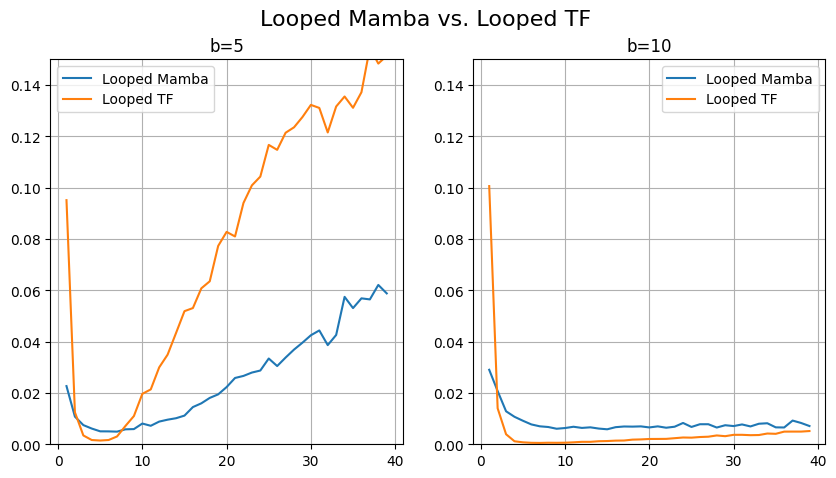

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle('Looped Mamba vs. Looped TF', fontsize=16)

axs[0].set_title('b=5')
axs[0].plot(steps_b5, values_b5)
axs[0].plot(steps_base_b5, values_base_b5)
axs[0].set_ylim([0, 0.15])
axs[0].grid()
axs[0].legend(["Looped Mamba", "Looped TF"])

axs[1].set_title('b=10')
axs[1].plot(steps_b10, values_b10)
axs[1].plot(steps_base_b10, values_base_b10)
axs[1].set_ylim([0, 0.15])
axs[1].grid()
axs[1].legend(["Looped Mamba", "Looped TF"])
fig.savefig("../images/looped_mamba_vs_looped_tf.png")